# 1. Data import

## 1.1 Importing the dataframes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import math as math
from scipy import stats
import importlib
import project_functions

Here, we import functions we created in a previous notebook, so we can clean / reformat the column headers

In [2]:
importlib.reload(project_functions)

<module 'project_functions' from 'c:\\Users\\Carlos\\Desktop\\Vanguard-AB-Testing\\project_functions.py'>

In [3]:
# cleaning the columns : changing the columns headers to correct format
# for more information about this function --> cf project_functions.py notebook
clean_my_columns = project_functions.clean_my_columns

Now, we 'instance' our dataframes so we precise to Python to read them:

In [4]:
# df creation
# reading the various datasets:
df_pt1 = pd.read_csv('raw_data/df_final_web_data_pt_1.txt')
df_pt2 = pd.read_csv('raw_data/df_final_web_data_pt_2.txt')
df_users = pd.read_csv('raw_data/df_final_demo.txt')
df_exp =pd.read_csv('raw_data/df_final_experiment_clients.txt')

We apply column titles cleaning to every dataframe

In [ ]:
clean_my_columns(df_exp)

clean_my_columns(df_users)

clean_my_columns(df_pt1)

clean_my_columns(df_pt2)

## 1.2 Looking at the dataframes

### 1.2.0 Info about DF's

In [ ]:
df_users.info(include='all')

In [ ]:
df_exp.info(include='all')

In [ ]:
df_pt1.info(include='all')

In [ ]:
df_pt2.info(include='all')

### 1.2.1 DF "Experiment participation"

The exp dataframe states whether a client (client_id) is being redirected on the original version (control) or to the new version (test)

In [ ]:
display(df_exp)
df_exp.shape

### 1.2.2 DF "Clients's Demographic"

In [ ]:
display(df_users)
df_users.shape

### 1.2.3 "Footprints Data" - 2 Tables

In [ ]:
display(df_pt1.head())
df_pt1.shape

In [ ]:
display(df_pt2.head())
df_pt2.shape

## 1.3 Combining tables

We're combining both group of tabless due to we have the same data columns within them.

### 1.3.1 Combining Footprints Tables:

In [14]:
# Combining df_pt_1 and df_pt_2:
df_footprint=pd.concat([df_pt1,df_pt2])

In [ ]:
#Now we take a overview about the concatenated table
display(df_footprint.head())

print(f"shape of pt1: {df_pt1.shape}")
print(f"shape of pt2: {df_pt2.shape}")
print(f"shape of the concat: {df_footprint.shape}")

Let's see how many unique clients we have data.

In [17]:
# Number of clients
df_footprint['client_id'].nunique()

120157

### 1.3.2 Combining Demo and Experiment tables

Experiment a demo tables have the exactly same shape and they have client_id in common, soy we are going to merge them to have the second column from experiment as another variable in our big table "demographics". 

In [19]:
df_clients = df_users.merge(df_exp, on='client_id', how='left')

In [ ]:
display(df_clients)
df_clients.shape

# 2. Cleaning Dataframes

## 2.1 Cleaning Clients Table

### 2.1.1 Duplicates

In [37]:
# Let's check how many duplicated rows there are.
duplicates_clients = df_clients.duplicated(keep=False)
df_duplicates_clients = df_clients[duplicates_clients]

print(df_duplicates_clients)

Empty DataFrame
Columns: [client_id, clnt_tenure_yr, clnt_tenure_mnth, clnt_age, gendr, num_accts, bal, calls_6_mnth, logons_6_mnth, variation]
Index: []


In [ ]:
# Deleting all duplicates
df_clients_nd = df_clients.drop_duplicates(keep=False)

print(df_clients_nd)

### 2.1.2 Nulls

In [ ]:
missing_clients_data = df_clients_nd.isnull().sum()
print(missing_clients_data)

We procced to drop rows with nulls data (20109 rows)

In [ ]:
df_clients_nd_nn = df_clients_nd.dropna()

print(df_clients_nd_nn)

### 2.1.3 Column client_id

* Checking unique values

In [49]:
df_clients_nd_nn.shape

(50487, 10)

In [51]:
df_clients_nd_nn['client_id'].nunique()

50487

Unique values for id_client is the same than shape, so we assume it is cleaned.

### 2.1.4 Column clnt_tenure_yr

In [ ]:
display(df_clients_nd_nn['clnt_tenure_yr'])
print(f"Valor mínimo: {df_clients_nd_nn['clnt_tenure_yr'].min()}")
print(f"Valor máximo: {df_clients_nd_nn['clnt_tenure_yr'].max()}")

We change the column datatype:

In [ ]:
df_clients_nd_nn['clnt_tenure_yr'] = df_clients_nd_nn['clnt_tenure_yr'].astype(int)

In [ ]:
df_clients_nd_nn['clnt_tenure_yr'].unique()

### 2.1.5 Column clnt_tenure_mnth

In [ ]:
display(df_clients_nd_nn['clnt_tenure_mnth'])
print(f"Valor mínimo: {df_clients_nd_nn['clnt_tenure_mnth'].min()}")
print(f"Valor máximo: {df_clients_nd_nn['clnt_tenure_mnth'].max()}")

We change the column datatype:

In [ ]:
df_clients_nd_nn['clnt_tenure_mnth'] = df_clients_nd_nn['clnt_tenure_mnth'].astype(int)

In [ ]:
df_clients_nd_nn['clnt_tenure_mnth'].unique()

Let's see if moonths and years of tenure are coherent. 

In [ ]:
# Comprobamos si hay filas donde los meses son mayores o iguales a 12 pero no coinciden con los años
df_inconsistencias = df_clients_nd_nn[(df_clients_nd_nn['clnt_tenure_mnth'] >= 12) & (df_clients_nd_nn['clnt_tenure_yr'] != df_clients_nd_nn['clnt_tenure_mnth'] // 12)]

# Mostrar filas con inconsistencias
print(df_inconsistencias)

Let's drop that inconsistences:

In [79]:
df_clients_nd_nn_in = df_clients_nd_nn.drop(df_inconsistencias.index)

### 2.1.6 Column client_age

In [ ]:
display(df_clients_nd_nn_in['clnt_age'])
print(f"Valor mínimo: {df_clients_nd_nn_in['clnt_age'].min()}")
print(f"Valor máximo: {df_clients_nd_nn_in['clnt_age'].max()}")

We round the client's age.We add the column.

In [83]:
df_clients_nd_nn_in['edad_redondeada'] = df_clients_nd_nn_in['clnt_age'].round()

Let's graph ages

In [ ]:
# Supongamos que tu DataFrame tiene una columna llamada 'edad'
df_clients_nd_nn_in['edad_redondeada'].value_counts().sort_index().plot(kind='bar', figsize=(10,6))

# Añadir título y etiquetas
plt.title('Distribución de Edades de los Clientes')
plt.xlabel('Edad')
plt.ylabel('Número de Clientes')

# Mostrar el gráfico
plt.show()

### 2.1.7 Column gender

In [ ]:
display(df_clients_nd_nn_in['gendr'])
print(f"Valor mínimo: {df_clients_nd_nn_in['gendr'].min()}")
print(f"Valor máximo: {df_clients_nd_nn_in['gendr'].max()}")

Check unique values

In [ ]:
unique_genders = df_clients_nd_nn_in['gendr'].unique()
count_genders = df_clients_nd_nn_in['gendr'].value_counts()
print("\nValores únicos en la columna 'gendr':")
print(unique_genders)
print(count_genders)

Let's replace X by U in those 2 values with X gender. 

In [93]:
df_clients_nd_nn_in['gendr'] = df_clients_nd_nn_in['gendr'].replace('X', 'U')

In [91]:
# In case you wannna drop those.
# df_clients_nd_nn_in_gdr = df_clients_nd_nn_in[df_clients_nd_nn_in['gendr'] != 'X']

### 2.1.8 Column num_accts

In [ ]:
display(df_clients_nd_nn_in['num_accts'])
print(f"Valor mínimo: {df_clients_nd_nn_in['num_accts'].min()}")
print(f"Valor máximo: {df_clients_nd_nn_in['num_accts'].max()}")

We change the column datatype:

In [95]:
df_clients_nd_nn_in['num_accts'] = df_clients_nd_nn_in['num_accts'].astype(int)

In [ ]:
df_clients_nd_nn_in['num_accts'].value_counts()

### 2.1.9 Column bal

In [ ]:
display(df_clients_nd_nn_in['bal'])
print(f"Valor mínimo: {df_clients_nd_nn_in['bal'].min()}")
print(f"Valor máximo: {df_clients_nd_nn_in['bal'].max()}")

In [ ]:
df_clients_nd_nn_in['num_accts'].value_counts()

### 2.1.10 Column calls_6_month

In [ ]:
display(df_clients_nd_nn_in['calls_6_mnth'])
print(f"Valor mínimo: {df_clients_nd_nn_in['calls_6_mnth'].min()}")
print(f"Valor máximo: {df_clients_nd_nn_in['calls_6_mnth'].max()}")

In [ ]:
df_clients_nd_nn_in['calls_6_mnth'].value_counts()

Let's turn into int

In [109]:
df_clients_nd_nn_in['calls_6_mnth'] = df_clients_nd_nn_in['calls_6_mnth'].astype(int)

### 2.1.11 Column logons_6_mnth

In [ ]:
display(df_clients_nd_nn_in['logons_6_mnth'])
print(f"Valor mínimo: {df_clients_nd_nn_in['logons_6_mnth'].min()}")
print(f"Valor máximo: {df_clients_nd_nn_in['logons_6_mnth'].max()}")

In [ ]:
df_clients_nd_nn_in['logons_6_mnth'].value_counts()

In [115]:
df_clients_nd_nn_in['logons_6_mnth'] = df_clients_nd_nn_in['logons_6_mnth'].astype(int)

## 2.2 Cleaning Footprints Table

### 2.2.1 Duplicates

In [ ]:
# Let's check how many duplicated rows there are.
duplicates = df_footprint.duplicated(keep=False)
df_duplicates = df_footprint[duplicates]

print(df_duplicates)

In [ ]:
# Deleting all duplicates
df_footprint_nd = df_footprint.drop_duplicates(keep=False)

print(df_footprint_nd)

### 2.2.2 Drop Clients not in experiment

In [ ]:
#create list of client_ids: 
clients_list = list(df_clients['client_id'])
clients_list

Because we need to put an eye only in the clients who we know are in the experiment (so, the list of clients in df_clients), we are deleting the rest of clients. 

In [ ]:
#creating new dataframe with footprints only with clients from clients list
df_sample_fp = df_footprint_nd.loc[df_footprint_nd['client_id'].isin(clients_list)]

df_sample_fp.shape

### 2.2.3 Nulls

Let's see now if we have nulls values

In [ ]:
missing_data = df_footprint_nd.isnull().sum()
print(missing_data)

## 'NaN'

df_clients_nd_nn.shape

First, we remove the rows where NaN appear on the variation column:

More concretely, we remove the clients not participating to the A/B testing

In [39]:
#df_sample_client = df_sample_client.merge(df_exp, on='client_id', how='left')

In [14]:
df_exp.shape

(70609, 2)

In [15]:
#drop N/As from users dataframe
no_nulls=df_exp.dropna(subset = ['variation'], inplace=True)

In [16]:
#check shape
df_exp.shape

(50500, 2)

In [17]:
#check nulls again
df_exp.isna().sum()

client_id    0
variation    0
dtype: int64

## 2.2 Cleaning df_users

### 2.2.1 Filtering / sampling

Let's filter footprints to keep only clients from experiment

In [ ]:
#creating new dataframe only with clients from clients list

clients_list = list(df_exp['client_id'])
clients_list

df_sample_client= df_users.loc[df_users['client_id'].isin(clients_list)]

df_sample_client.head()

In [19]:
len(df_sample_client)

50500

### 2.2.2 Null values cleaning

In [ ]:
# list clients with null values

list_nulls = df_sample_client[df_sample_client.drop(columns=['client_id']).isnull().all(axis=1)]
len(list_nulls)

In [ ]:
len(df_sample_client)

In [ ]:
#Let's now remove the clients with null values from our dataframe:
df_sample_client= df_sample_client.drop(df_sample_client[df_sample_client['client_id'].isin(list_nulls['client_id'])].index)
df_sample_client

In [23]:
# check for nulls in each column of df_sample_client
list_nulls.isna().sum()

client_id            0
clnt_tenure_yr      12
clnt_tenure_mnth    12
clnt_age            12
gendr               12
num_accts           12
bal                 12
calls_6_mnth        12
logons_6_mnth       12
dtype: int64

OK we're good for the client_ids

In [24]:

#list of clients with null values
list_nulls = df_sample_client[df_sample_client.drop(columns=['client_id']).isnull().all(axis=1)]
list_nulls

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth


In [25]:
df_sample_client.shape

(50488, 9)

In [29]:
df_sample_client.isnull().sum()

client_id           0
clnt_tenure_yr      0
clnt_tenure_mnth    0
clnt_age            1
gendr               0
num_accts           0
bal                 0
calls_6_mnth        0
logons_6_mnth       0
dtype: int64

Ya no quedan nulos en la tabla. 

# 3. Exporting our cleaned dataframes

In [45]:
#Exporting clean dataframes to csv

df_footprint.to_csv('clean_data/df_footprint.csv', index=False)

df_users.to_csv('clean_data/df_users.csv', index=False)

df_exp.to_csv('clean_data/df_exp_clean.csv', index=False)

df_sample_client.to_csv('clean_data/df_sample_client_clean.csv', index=False)

df_sample_fp.to_csv('clean_data/df_sample_fp_clean.csv', index=False)

# 4. Client behavior analysis

## 4.1 Sample analysis

### 4.1.1 Primary clients: Let's see which kind of gender there are

In [46]:
df_sample_client.groupby(['gendr'])['client_id'].count()

gendr
F    16259
M    16947
U    17282
Name: client_id, dtype: int64

<Axes: xlabel='gendr', ylabel='Count'>

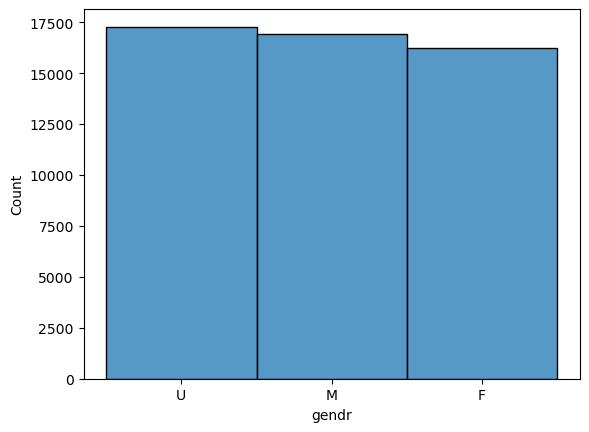

In [47]:
sns.histplot(df_sample_client, x="gendr")

In [48]:
df_sample_client.groupby(['variation','gendr'])['client_id'].count()

variation  gendr
Control    F        7543
           M        7970
           U        8014
Test       F        8716
           M        8977
           U        9268
Name: client_id, dtype: int64

In [52]:
df1 = df_sample_client.groupby(['variation','gendr'])['client_id'].count()

In [53]:
df1

variation  gendr
Control    F        7543
           M        7970
           U        8014
Test       F        8716
           M        8977
           U        9268
Name: client_id, dtype: int64

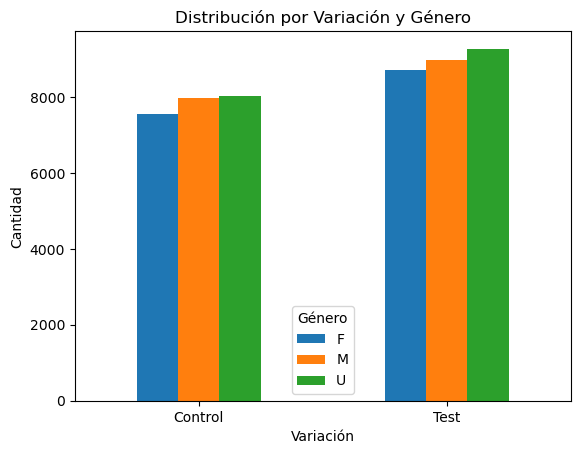

In [54]:
# Crear el DataFrame a partir de tu estructura
data_gender = {
    ('Control', 'F'): 7543,
    ('Control', 'M'): 7970,
    ('Control', 'U'): 8014,
    ('Test', 'F'): 8716,
    ('Test', 'M'): 8977,
    ('Test', 'U'): 9268
}

# Convertir el diccionario en un DataFrame con MultiIndex
df_gender = pd.Series(data_gender).unstack()

# Hacer el gráfico de barras
df_gender.plot(kind='bar')

# Configurar etiquetas y título
plt.title('Distribución por Variación y Género')
plt.xlabel('Variación')
plt.ylabel('Cantidad')
plt.legend(title='Género')
plt.xticks(rotation=0)

# Mostrar gráfico
plt.show()

### 4.1.2 Clients by Tenure

<Axes: xlabel='clnt_tenure_yr', ylabel='Count'>

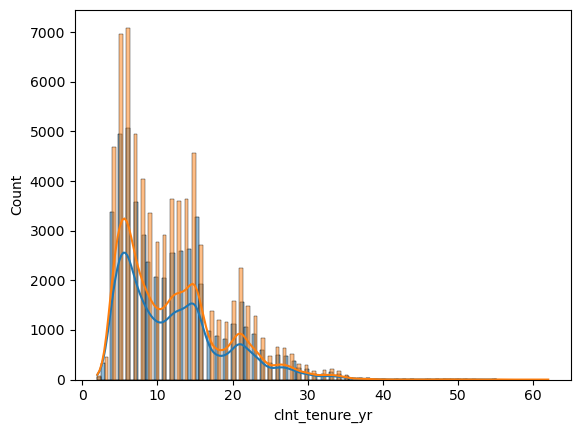

In [55]:
plt.figure()
#sns.histplot(df_sample_client, x="clnt_tenure_yr")
#kde keyword adds a line that represents the shape of the histogram
sns.histplot(df_sample_client, x="clnt_tenure_yr",kde=True)
sns.histplot(df_users, x="clnt_tenure_yr", kde=True)

In [ ]:
plt.figure(figsize=(10,10))
sns.histplot(df_sample_client, x="clnt_tenure_yr",kde=True)
sns.histplot(df_users, x="clnt_tenure_yr", kde=True)

### 4.1.3 Clients by Age

In [ ]:
sns.histplot(df_sample_client, x="clnt_age")

<Axes: xlabel='clnt_age', ylabel='Count'>

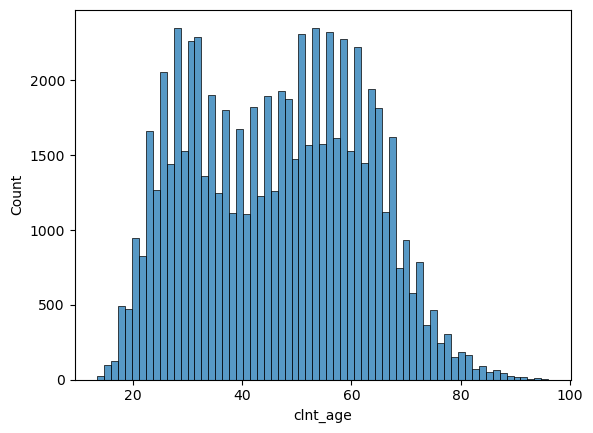

In [61]:
sns.histplot(df_users, x="clnt_age")

In [ ]:
plt.figure(figsize=(10,10))
#sns.histplot(df_sample_client, x="clnt_tenure_yr")
#kde keyword adds a line that represents the shape of the histogram
sns.histplot(df_sample_client, x="clnt_age",kde=True)
sns.histplot(df_users, x="clnt_age", kde=True)

### 4.1.4 Others

In [ ]:
df_sample_client['clnt_tenure_yr'].describe()

In [ ]:
df_users['clnt_tenure_yr'].describe()

In [ ]:
print(df_sample_client['clnt_age'].describe())

print(df_users['clnt_age'].describe())

In [ ]:
print(df_sample_client['bal'].describe())

print(df_users['bal'].describe())

### 4.1.5 explicacion kde

La opción kde=True en sns.histplot de Seaborn añade una estimación de densidad kernel (Kernel Density Estimate, KDE) al gráfico de histograma. En lugar de solo mostrar las barras del histograma, que representan la frecuencia de los datos en cada bin, la curva KDE te da una representación suave de la distribución de los datos.

¿Qué es la estimación de densidad kernel (KDE)?
La KDE es una forma de estimar la función de densidad de probabilidad de una variable continua. En lugar de contar los datos en intervalos discretos como en un histograma, la KDE usa una función kernel (una curva suave, normalmente una gaussiana) para aproximar cómo se distribuyen los datos en el conjunto.

Ejemplo:
python
Copy code
import seaborn as sns
import matplotlib.pyplot as plt

Generar datos de ejemplo #
data = [1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 6, 7, 8, 9, 10]

Crear histograma con kde=True #
sns.histplot(data, kde=True)

Mostrar gráfico #
plt.show()
¿Qué hace kde=True?
Histograma: Muestra las barras de frecuencia de los datos.
KDE: Dibuja una curva suave sobre el histograma, que representa la densidad estimada de la distribución subyacente. La KDE intenta proporcionar una mejor visualización de la distribución de los datos que un histograma por sí solo, especialmente útil para datos continuos.
¿Cuándo usar KDE?
Datos continuos: La KDE es más adecuada para datos continuos donde la distribución es más fluida.
Suavidad: Es útil cuando quieres visualizar una versión suavizada del histograma, especialmente si los datos tienen picos y valles que podrían suavizarse con la curva.
Tamaño de muestra pequeño: Si tienes pocos datos, un histograma puede dar una imagen errónea de la distribución real. La KDE ayuda a suavizar la representación.
En resumen, kde=True añade una curva que representa la distribución subyacente de los datos de forma suave, complementando el histograma para dar una mejor idea de la distribución.

# 5. KPI's and Meters

## 5.0 New imports

In [68]:
# import all the necessary libraries
from statsmodels.stats.proportion import proportions_ztest
import math as math
from scipy import stats
import pymysql
from sqlalchemy import create_engine
import getpass  # To get the password without showing the input
password = getpass.getpass()

In [67]:
# import the datafiles
df_clean_fp =pd.read_csv('clean_data/df_sample_fp_clean.csv')
df_clean_clients = pd.read_csv('clean_data/df_sample_client_clean.csv')
df_exp_clean =pd.read_csv('clean_data/df_exp_clean.csv')

## 5.1 Conversion Rates prep

In [ ]:
# create new table for conversion counts
df_conv=df_clean_fp.groupby(['client_id', 'process_step']).size().reset_index()
df_conv.columns.values[[ 2]] = [ 'counts']
df_conv=df_conv.pivot(index='client_id', columns='process_step', values='counts')
df_conv

Creamos nueva columna (de start a confirm) para contar los éxitos

In [ ]:
# create new column for conversion (from start to confirm) to count the conversions rate
df_conv['conversion'] = (
    (df_conv['start'] >= 1) & 
    (df_conv['step_1'] >= 0) & 
              (df_conv['step_2'] >= 0) & 
     (df_conv['step_3'] >= 0) &
     (df_conv['confirm'] >= 1)
 ).astype(int)
# Sum of clients who succeeded to go through the whole process and converted
total_conversions = df_conv['conversion'].sum()

print("Total conversions:", total_conversions)

df_conv

Otra columna para los completed and confused

In [71]:
# create new column for completed & confused
df_conv['completed_&_confused'] = (
    (df_conv['start'] >= 1) & 
    ((df_conv['step_1'] > 1) |
     (df_conv['step_2'] > 1) |
     (df_conv['step_3'] > 1)) & 
    (df_conv['confirm'] >= 1)
).astype(int)

Otra columna para completed y Linear

In [73]:
# create new column for completed & linear

df_conv['completed_linear'] = (
    (df_conv['start'] == 1) & 
    (df_conv['step_1'] == 1) & 
    (df_conv['step_2'] == 1) & 
    (df_conv['step_3'] == 1) & 
    (df_conv['confirm'] == 1)
).astype(int)

Ahora hacemos merge de conv con exp_clean para client ID

In [ ]:
# merge df_conv with df_exp_clean on client_id

df_conv= pd.merge(df_conv, df_exp_clean, on='client_id')
df_conv

Exportamos a un csv

In [75]:
# Exporting df_conv to csv to use in hypothesis testing

pd.DataFrame.to_csv(df_conv, 'df_conv.csv')

Creamos función que crea tabla seccion cruzada con una columna que enseña si los clientes están asignados a test o control

In [76]:
# function that creates a crosstable with a column showing if the clients are assigned to the control
# or to the test group
def create_cross_tab(df, stat):
    df_cross = pd.DataFrame({
        'variation': ['control', 'test'], 

        'conversion': [
            
            sum(df[df['variation'] == 'Control'][stat]),
            sum(df[df['variation'] == 'Test'][stat])
        ], 
        'total': [

            len(df[df['variation'] == 'Control']),
            len(df[df['variation'] == 'Test'])],

        'proportion':[
            sum(df[df['variation'] == 'Control'][stat]) / len(df[df['variation'] == 'Control']),
            sum(df[df['variation'] == 'Test'][stat]) / len(df[df['variation'] == 'Test'])
        ]
    })
    return df_cross

## 5.1 Conversion Rates

Usamos create_cross_tab función para obtener los ratios de conversion por grupo y calcular su proporción.

In [77]:
# we use the create_cross_tab function to get the conversion rates per group
# and calculate the proportion as %
conv_rate = create_cross_tab(df_conv, 'conversion')
conv_rate["100*prop"] = conv_rate["proportion"]*100
conv_rate

,variation,conversion,total,proportion,100*prop
0,control,15201,23527,0.646109,64.610873
1,test,18333,26961,0.679982,67.998220


Calculamos el porcentaje de usuarios que confirmaron eb vez de reakuzar errores

<Axes: xlabel='variation', ylabel='proportion'>

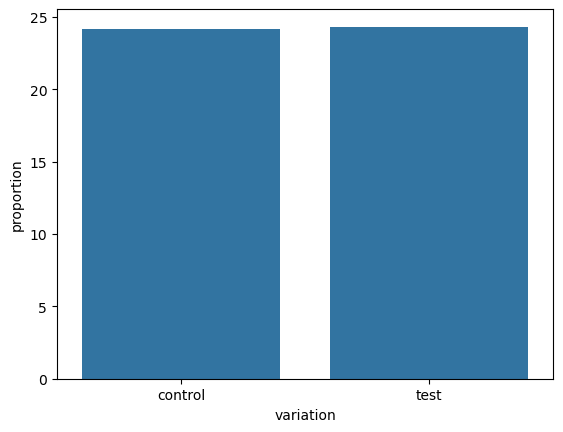

In [78]:
#we calculate the percent of users that confirmed in spite of making mistakes
non_lin_rate = create_cross_tab(df_conv, 'completed_&_confused')
sns.barplot(x='variation', y=non_lin_rate['proportion']*100, data=non_lin_rate)

## 5.2 Completed Linear Rate

,variation,conversion,total,proportion
0,control,7071,23527,0.300548
1,test,8246,26961,0.305849


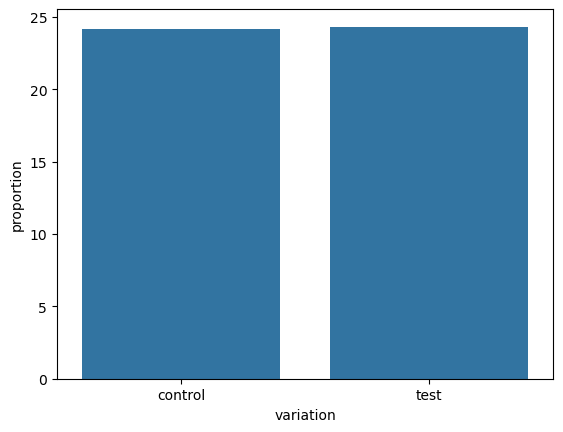

In [79]:
#the client confirmed after doing each step once
lin_rate = create_cross_tab(df_conv, 'completed_linear')
sns.barplot(x='variation', y=non_lin_rate['proportion']*100, data=lin_rate)
lin_rate

# 6. Errors

In [80]:
#counts moving from one step to the previous one

#we convert the time column to date_time format the values by date
df_clean_fp.date_time=pd.to_datetime(df_clean_fp.date_time)

#we sort the values by date
df_clean_fp = df_clean_fp.sort_values(by=['date_time'])

#we add a column where the process_step and the client_id are lagged by 1 step
df_clean_fp['process_step_lagged'] = df_clean_fp.groupby(['visit_id'])['process_step'].shift(1)
df_clean_fp["client_id_lagged"] = df_clean_fp.groupby(['visit_id'])['client_id'].shift(1)

test = df_clean_fp

#this loop identifies and counts the errors (the points where the user 
#went back), and adds a column (boolean)
#to identify which clients had errors (called error)

error_counter_1 = 0 #error: step_1 back to start
error_counter_2 = 0 #error: step_2 back to step_1
error_counter_3 = 0 #error: step_3 back to step_2
error_counter_4 = 0 #error: confirm back to step_3
no_error_counter = 0
test["error"] = 0
test["error_loc"] = 0
for index, row in test.iterrows():
    if (row["process_step"] == "start") and (row["process_step_lagged"] == "step_1") and (row["client_id"] == row["client_id_lagged"]):
        error_counter_1 = error_counter_1 + 1
        test.at[index,"error"] = 1
        test.at[index,"error_loc"] = row["process_step_lagged"] 
    elif (row["process_step"] == ("step_1")) and (row["process_step_lagged"] == "step_2") and (row["client_id"] == row["client_id_lagged"]):
        error_counter_2 = error_counter_2 + 1
        test.at[index,"error"] = 1
        test.at[index,"error_loc"] = row["process_step_lagged"] 
    elif (row["process_step"] == ("step_2")) and (row["process_step_lagged"] == "step_3") and (row["client_id"] == row["client_id_lagged"]):
        error_counter_3 = error_counter_3 + 1
        test.at[index,"error"] = 1
        test.at[index,"error_loc"] = row["process_step_lagged"] 
    elif (row["process_step"] == ("step_3")) and (row["process_step_lagged"] == "confirm") and (row["client_id"] == row["client_id_lagged"]):
        error_counter_4 = error_counter_4 + 1
        test.at[index,"error"] = 1
        test.at[index,"error_loc"] = row["process_step_lagged"] 
    else:
        no_error_counter = no_error_counter + 1
        test.at[index,"error"] = 0
        test.at[index,"error_loc"] = None 
print(f"Error counter 1 (step_1 --> start): {error_counter_1}")
print(f"Error counter 2 (step_2 --> step_1): {error_counter_2}")
print(f"Error counter 3 (step_3 --> step_2): {error_counter_3}")
print(f"Error counter 4 (confirm --> step_3): {error_counter_4}")
print(f"No error counter: {no_error_counter}")

C:\Users\Carlos\AppData\Local\Temp\ipykernel_21476\2225182757.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'step_2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test.at[index,"error_loc"] = row["process_step_lagged"]


Error counter 1 (step_1 --> start): 8883
Error counter 2 (step_2 --> step_1): 4526
Error counter 3 (step_3 --> step_2): 4638
Error counter 4 (confirm --> step_3): 149
No error counter: 303011


[2.77, 1.41, 1.44, 0.05, 94.34]


<Axes: >

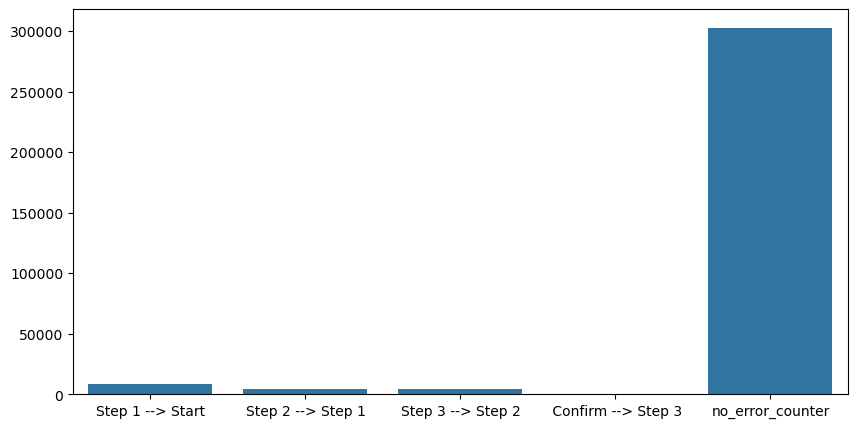

In [81]:
x = ["Step 1 --> Start","Step 2 --> Step 1","Step 3 --> Step 2"," Confirm --> Step 3","no_error_counter"]
y = [error_counter_1,error_counter_2,error_counter_3,error_counter_4,no_error_counter]

errors = pd.DataFrame(x,y)

list_percent = []
for i in y:
    list_percent.append(round(i*100/sum(y),2))
print(list_percent)

plt.figure(figsize=(10,5))
sns.barplot(errors,x=x,y=y)

In [82]:
#create a dataframe with error counters and location 
df_errors = pd.DataFrame(test,columns=["client_id","error","error_loc"])
df_errors

,client_id,error,error_loc
34716,7179755,0,NaN
34715,7179755,0,NaN
34714,7179755,0,NaN
34713,7179755,0,NaN
34712,7179755,0,NaN
...,...,...,...
289826,291330,0,None
318744,1558312,0,None
289346,6187864,0,None
289345,6187864,0,None


In [83]:
df_errors= pd.merge(df_errors, df_exp_clean, on='client_id')
df_errors.to_csv("df_errors.csv")

In [84]:
error_counter = create_cross_tab(df_errors,"error")
error_counter['prop*100']=error_counter['proportion']*100

In [85]:
error_counter

,variation,conversion,total,proportion,prop*100
0,control,6358,143420,0.044331,4.433133
1,test,11838,177787,0.066585,6.658530


In [86]:
#exporting to csv
error_counter.to_csv("df_error_counter.csv")

In [87]:
#This is a placeholder for the actual average time values
# just change the values here and rerun this cell and the one below to update the figure
time = pd.DataFrame({
    'variation': ['control', 'test'], 
    'duration': [268.7412,288.7408]
})
time

,variation,duration
0,control,268.7412
1,test,288.7408


Text(0, 0.5, 'Error rate (%)')

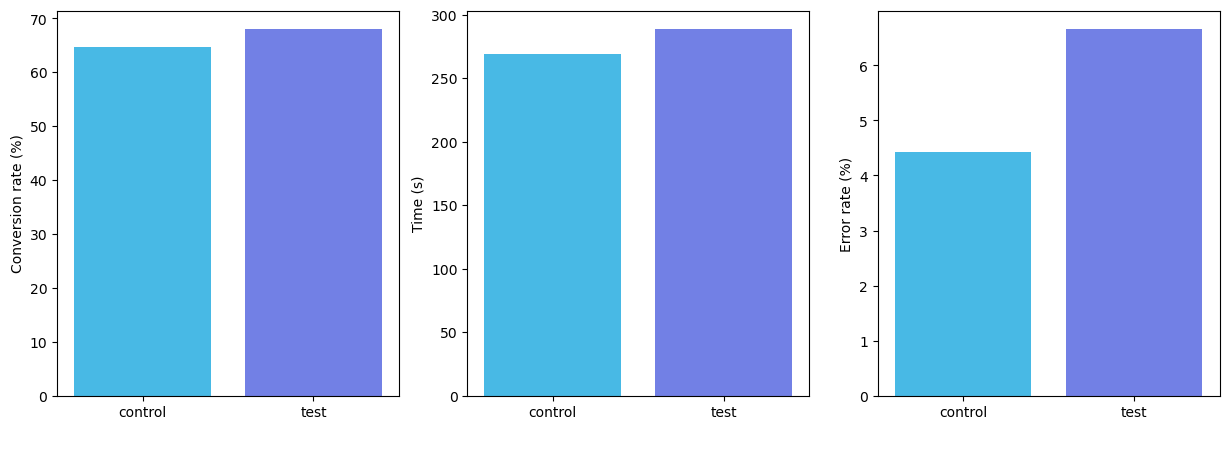

In [88]:
#vertical figure to summarize the KPI
color='#42a4fc'
palette = ['#2ec5ff','#5f72f8']
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(1,3,1)
sns.barplot(x='variation', y='100*prop', data=conv_rate, hue='variation', palette=palette)
plt.xlabel(" ")
plt.ylabel("Conversion rate (%)")

ax2 = plt.subplot(1,3,2)
sns.barplot(x='variation', y='duration', data=time, hue='variation', palette=palette)
plt.xlabel(" ")
plt.ylabel("Time (s)")

ax3 = plt.subplot(1,3,3)
sns.barplot(x='variation', y='prop*100', data=error_counter, hue='variation', palette=palette)
plt.xlabel(" ")
plt.ylabel("Error rate (%)")

#plt.savefig("conversion_rate.png")

# 7. Time duration (Pendiente)

# 8. Contraste de Hipótesis

## 8.1 Prep

In [6]:
df_conv=pd.read_csv('df_conv.csv')
df_error_counter=pd.read_csv("df_error_counter.csv")

In [ ]:
df_time= pd.read_csv("vanguard - process step diff and step time per client id, per visit_id.csv")

In [9]:
df_exp = pd.read_csv("clean_data/df_exp_clean.csv")

In [10]:
df_error_counter

,Unnamed: 0,variation,conversion,total,proportion,prop*100
0,0,control,6358,143420,0.044331,4.433133
1,1,test,11838,177787,0.066585,6.658530


## Z-test proportion test 

Based on https://towardsdatascience.com/a-b-testing-with-binary-data-two-sample-proportions-z-test-5c222d7772ad!

In [11]:
def create_df_ztest(df,stat):
    pd.DataFrame({
    'variation': ['control', 'test'], 
    'conversion': [
        
        sum(df[df['variation'] == 'Control'].stat),
        sum(df[df['variation'] == 'Test'].stat)
    ], 
  
    'total': [

        len(df[df['variation'] == 'Control']),
        len(df[df['variation'] == 'Test'])],

    'proportion':[
        sum(df[df['variation'] == 'Control'].stat) / len(df[df['variation'] == 'Control']),
        sum(df[df['variation'] == 'Test'].stat) / len(df[df['variation'] == 'Test'])
    ]
})

In [13]:
# create data frame with counts of conversion in test and control group with extra column with total counts per sample
df_ztest = pd.DataFrame({
    'variation': ['control', 'test'], 
    'conversion': [
        
        sum(df_conv[df_conv['variation'] == 'Control'].conversion),
        sum(df_conv[df_conv['variation'] == 'Test'].conversion)
    ], 
  
    'total': [

        len(df_conv[df_conv['variation'] == 'Control']),
        len(df_conv[df_conv['variation'] == 'Test'])],

    'proportion':[
        sum(df_conv[df_conv['variation'] == 'Control'].conversion) / len(df_conv[df_conv['variation'] == 'Control']),
        sum(df_conv[df_conv['variation'] == 'Test'].conversion) / len(df_conv[df_conv['variation'] == 'Test'])
    ]
})

In [14]:
df_ztest

,variation,conversion,total,proportion
0,control,15201,23527,0.646109
1,test,18333,26961,0.679982


In [15]:
df_error_counter

,Unnamed: 0,variation,conversion,total,proportion,prop*100
0,0,control,6358,143420,0.044331,4.433133
1,1,test,11838,177787,0.066585,6.658530


In [ ]:
#run proportion test
#proportions_ztest(count=[18333, 15201], nobs=[26959,23527], alternative='larger')

In [ ]:
# Z-test definitions: 

# p1 = proportion of successes in sample 1 (control group)
# p2 = proportion of successes in sample 2 (test group)

# n1 = number of trials in sample 1
# n2 = number of trials in sample 2

#The null hypothesis states that there is no difference in the proportions, while 
#the alternative hypothesis says that proportion 1 is less than proportion 2. I.e., there is an effect of the new design.

# H0: p1 = p2
# H1: p1 < p2 (left-tailed test)

In [20]:
# Estimate sample size for z-test

def z_calc(p1, p2, n1, n2):
    p_star = (p1*n1 + p2*n2) / (n1 + n2)
    return (p2 - p1) / math.sqrt(p_star*(1 - p_star)*((1.0 / n1) + (1.0 / n2)))

def sample_required(p1, p_diff, alpha):
    if p_diff <= 0:  # p_diff = p2-p1
        raise ValueError("p_diff must be > 0")
    n = 1
    while True:
        z = z_calc(p1, p1+p_diff, n1=n, n2=n)
        p = 1 - stats.norm.cdf(z)
        if p < alpha:
            break
        n += 1
    return n

sample_size = sample_required(df_ztest[['proportion'][0]][0],(df_ztest[['proportion'][0]][1] - df_ztest[['proportion'][0]][0]), 0.05)

sample_size

1054

The minimum sample size is 1051 for each group. (this is an extra step - in our case the samples were very big anyway)

In [21]:
# Create new data frame with random sample for the z-test

df_tr = df_conv[df_conv['variation'] == 'Test']
df_ctrl = df_conv[df_conv['variation'] == 'Control']

In [22]:
df_tr_sample = df_tr.sample(n=20000, random_state=23)
df_ctrl_sample = df_ctrl.sample(n=20000, random_state=23)

In [23]:
df_sample = pd.concat([df_tr_sample, df_ctrl_sample], ignore_index=True)
df_sample.head(2)

,Unnamed: 0,client_id,confirm,start,step_1,step_2,step_3,conversion,completed_&_confused,completed_linear,variation
0,39485,7800773,NaN,3.0,1.0,1.0,NaN,0,0,0,Test
1,1518,301969,1.0,4.0,2.0,2.0,1.0,1,1,0,Test


In [24]:
df_sample_gr = df_sample.groupby('variation').agg({'conversion':'sum',
                                                    'client_id':'nunique'}).reset_index()

In [25]:
df_sample_gr['proportion'] = (df_sample_gr['conversion']) / df_sample_gr['client_id']

In [26]:
df_sample_gr

,variation,conversion,client_id,proportion
0,Control,12899,20000,0.64495
1,Test,13581,20000,0.67905


### Z-test and results

In [27]:
number_of_successes = [12899, 13626]
total_sample_sizes = [20000, 20000]

In [28]:
test_stat, p_value = proportions_ztest(number_of_successes, total_sample_sizes, alternative='smaller')

In [29]:
print("Computed z-test statistic: ", test_stat)
print("Computed p-value: ", p_value)

Computed z-test statistic:  -7.6908142674918025
Computed p-value:  7.310077118377838e-15


 In that case, we see that our result is statistically significant and we have evidence to reject the null hypothesis.

### Proportion z-test vs threshold 105%

In [30]:
#df_sample_gr

threshold=(sum(df_conv[df_conv['variation'] == 'Control'].conversion) / len(df_conv[df_conv['variation'] == 'Control']))*1.05
threshold

0.6784141624516513

In [31]:
# run z proportion test of test conversion vs p
# H0: p = p0
# H1: test > p

# Result cannot reject H0


proportions_ztest(count=18333, nobs=26959, value=threshold ,alternative='larger')

(0.5696937184289913, 0.2844427256392652)

### Duration per step testing (PENDIENTE)

In [ ]:
df_time.head()

In [ ]:
df_time.shape

In [ ]:
# boxplot of step_time  
sns.boxplot(  y='step_time', data=df_time)

In [ ]:
# remove nulls from df_time step_time

df_time2 = df_time.dropna(subset=['step_time'])

df_time2['step_time'].describe()

In [ ]:
#running again the boxplot
sns.boxplot(  y='step_time', data=df_time2)

In [ ]:
# Assigning 600 seconds max to the times >= 600s
df_time2['step_time'] = df_time2['step_time'].apply(lambda x : x if x < 600 else 600)


df_time2['step_time'].describe()

In [ ]:
df_time2.head()

In [ ]:
#DO NOT RUN
#removing outliers

def remove_outliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print("Lower Bound:", lower_bound)
    print("Upper Bound:", upper_bound)
    
    # Filter the DataFrame based on the condition
    filtered_data = data[(data[col] > lower_bound) & (data[col] < upper_bound)]

    return filtered_data

# Call the function and print the result
df_time_no_outliers = remove_outliers(df_time2, 'step_time')

In [ ]:
#DO NOT RUN
df_time_no_outliers.shape

In [ ]:
#running again the boxplot, but this time with 'replaced by 600 sec' outliers
sns.boxplot(  y='step_time', data=df_time2)

In [ ]:
# create series with control and test step_time 
time_test = df_time2[df_time2['Variation'] == 'Test']['step_time']
time_control = df_time2[df_time2['Variation'] == 'Control']['step_time']

In [ ]:
time_test.describe() 

In [ ]:
sns.histplot(time_test, kde=True, label='Test')
sns.histplot(time_control, kde=True, label='Control')

# Add legend
plt.legend()

# Show plot
plt.show()

In [ ]:
time_test.describe()

In [ ]:
time_control.describe()

In [ ]:
# mann whitney test for step time
# H0: test <= control
# H1: test > control
stats.mannwhitneyu(time_test, time_control, alternative='greater')

we cannot reject H0, meaning either test is smaller is there's no significant difference in terms of avg time duration

In [ ]:
df_tr_error = df_error_counter[df_error_counter['variation'] == 'Test']
df_ctrl_error = df_error_counter[df_error_counter['variation'] == 'Control']

In [ ]:
df_time2

In [ ]:
df_time2.to_csv('df_time2.csv')

In [ ]:
##Z-test on the error rates

In [ ]:
proportions_ztest(count=[11838, 6358], nobs=[177787,143420], alternative='larger')
#the error count in the test group is significantly larger than the error count on the 
# control group --> which may explain why the process wasn't more efficient and didn't meet
# the required threshold

Currently, we have the meaning of each column (variable) that we show here below: 

* client_id: Every client’s unique ID.
* variation: Indicates if a client was part of the experiment.
* visitor_id: A unique ID for each client-device combination.
* visit_id: A unique ID for each web visit/session.
* process_step: Marks each step in the digital process.
* date_time: Timestamp of each web activity.
* clnt_tenure_yr: Represents how long the client has been with Vanguard, measured in years.
* clnt_tenure_mnth: Further breaks down the client’s tenure with Vanguard in months.
* clnt_age: Indicates the age of the client.
* gendr: Specifies the client’s gender.
* num_accts: Denotes the number of accounts the client holds with Vanguard.
* bal: Gives the total balance spread across all accounts for a particular client.
* calls_6_mnth: Records the number of times the client reached out over a call in the past six months.
* logons_6_mnth: The frequency with which the client logged onto Vanguard’s platform over the last six months